# Gestion de Datos

Para contemplar el universo de probabilidades y compararlo con los resultados optimizados, se ha realizado una simulación de Monte Carlo.

In [85]:
n_samples = 10000

In [86]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

def plot_sharpe(returns, mask=None):
    # Generamos los pesos aleatoriamente
    n_assets = len(returns.iloc[0])
    mask = np.ones(n_assets) if mask is None else mask

    generator = np.random.default_rng(42)
    weights = generator.random(size=(n_samples, n_assets))
    weights = (mask * weights) / np.sum(weights, axis=1, keepdims=True)

    daily_returns = returns @ weights.T
    daily_returns_std = daily_returns.std(axis=0)
    daily_returns_mean = daily_returns.mean(axis=0)

    plt.scatter(x=daily_returns_std, y=daily_returns_mean, c=daily_returns_mean/daily_returns_std, marker="o", cmap="coolwarm")

    plt.grid(True)
    plt.xlabel("Riesgo (std)")
    plt.ylabel("Retorno esperado")
    plt.title("Retorno vs. Riesgo de carteras aleatorias")
    plt.show()

In [87]:
def get_data(csv=True):
    if csv:
        return pd.read_csv('resources/prod_long_sharpe_u50_20260116_v5_train_dataset.csv')
    else:

        tickers = [
          # --- Extrema Volatilidad & Cripto-Proxies ---
          'MSTR', 'MARA', 'RIOT', 'CLSK', 'COIN', 'CAN', 'WULF',

          # --- ETFs Apalancados (Varianza Extrema) ---
          'TQQQ', 'SOXL', 'UPRO', 'LABU', 'FNGU', 'YINN', 'BOIL', 'UVIX', 'TMF',

          # --- Tech Agresiva & Memes ---
          'TSLA', 'GME', 'AMC', 'PLTR', 'SNOW', 'U', 'PATH', 'AI', 'UPST',
          'CVNA', 'DKNG', 'HOOD', 'PYPL', 'RIVN', 'LCID', 'NIO',

          # --- Biotecnología (Gaps de precio) ---
          'MRNA', 'BNTX', 'SAVA', 'VKTX', 'CRSP', 'ILMN',

          # --- Commodities & Energía Volátil ---
          'XOP', 'UNG', 'XME', 'GDXJ', 'FCX', 'SQM', 'ALB',

          # --- China & Emergentes (Riesgo Político) ---
          'BABA', 'JD', 'PDD', 'KWEB',

          # --- Refugios (Para probar la lógica de asignación) ---
          'SHV', 'BIL'
        ]

        # Descarga de datos (2 años para tener historial suficiente)
        return yf.download(tickers, period="2y", interval="1d")['Close'].pct_change().dropna()

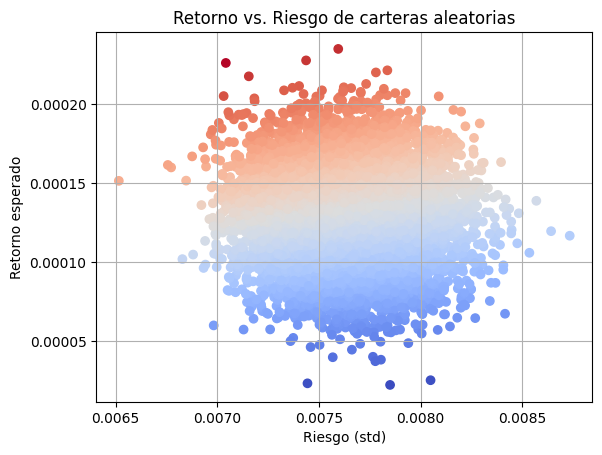

In [88]:

returns = get_data(csv=True)
if not len(returns):
    exit(-1)

plot_sharpe(returns)


Ahora que sabemos que aspecto tiene, vamos a filtrar los activos que tengan una correlación alta, para diversificar la cartera correctamente y reducir la volatilidad (si dos activos con una correlación alta sufren una caída del precio, esto condiciona nuestro ratio de sharpe).
Tambien calculamos la curtosis y eliminamos aquellos que tienen una curtosis muy alta

Mirar asimetrias tambien, queremos una cartera poco volatil y que nos permita maximizar el rendimiento sin sustos

{'asset1', 'asset27', 'asset40', 'asset8', 'asset42', 'asset15', 'asset21', 'asset20', 'asset2', 'asset16', 'asset22', 'asset34', 'asset18', 'asset41', 'asset14', 'asset39'}
[0, 26, 39, 7, 41, 14, 20, 19, 1, 15, 21, 33, 17, 40, 13, 38]


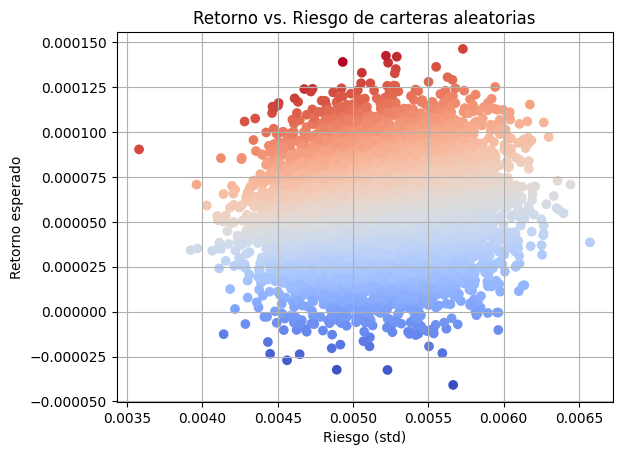

In [89]:
sharpe = returns.mean() / returns.std()

drop = set()

# Curtosis
kurtosis = returns.kurtosis()
for asset, _ in returns.items():
    if (kurtosis[asset] > 6):
        drop.add(asset)

# Obtenemos la correlacion absoluta
correlations = returns.corr().abs()
correlated = correlations[(correlations >= 0.8) & (correlations < 1)].stack()

for (a, b), _ in correlated.items():
    if a in drop or b in drop:
        continue
    if sharpe[a] > sharpe[b]:
        drop.add(b)
    else:
        drop.add(a)


drop_indexes = [returns.columns.get_loc(col) for col in drop]

print(drop)
print(drop_indexes)

mask = np.ones(len(returns.iloc[0]))
mask[drop_indexes] = 0

plot_sharpe(returns, mask)

Lo que usabamos antes:


´´
daily_returns = returns @ weights.T
daily_returns_std = daily_returns.std(axis=0)
daily_returns_mean = daily_returns.mean(axis=0)
Objective -> daily_returns_mean/daily_returns_std

No vale porque no es convexo



In [90]:
import cvxpy as cp

# Los assets con correlacion inferior al 80% y curtosis <= 6 y el activo de renta fija
n_assets = len(returns.iloc[0]) + 1

returns_cov = returns.cov()
returns_means = returns.mean(axis=0).values
returns_means = np.append(returns_means, (0.02 / 252)) # 2% se refiere a anual

min_expected_ret_daily = returns_means.min()
max_expected_ret_daily = returns_means.max() * 0.6

# CVXPY
best_weights = cp.Variable(n_assets)
portfolio_returns = returns_means.T @ best_weights
# La renta fija no afecta a la varianza (riesgo 0)
portfolio_variance = cp.quad_form(best_weights[:-1], returns_cov)

constraints = [
    cp.sum(best_weights) == 1, # Todo el capital debe estar invertido
    best_weights[:-1] <= 0.07, # No invertimos mas de un 7% en cada activo
    best_weights[-1] <= 0.1, # El activo de renta fija debe pesar como mucho un 10%
    best_weights >= 0, # No se permiten posiciones cortas
    best_weights[drop_indexes] == 0 # Evitamos dar peso a los activos muy relacionados o con curtosis alta
]

results = []
rf_daily = 0.02/252
for r_target in np.linspace(min_expected_ret_daily, max_expected_ret_daily, 200):

    r_constraints = constraints + [best_weights @ returns_means >= r_target]

    problem = cp.Problem(cp.Minimize(portfolio_variance), r_constraints)
    problem.solve(solver=cp.OSQP, warm_start=True)

    if best_weights.value is not None:
        ret = portfolio_returns.value
        vol = np.sqrt(portfolio_variance.value)
        sharpe_ratio = (ret - rf_daily) / vol if vol > 0 else 0
        row = np.concatenate([[ret], [vol], [sharpe_ratio], best_weights.value])
        results.append(row)

columns = ["return", "volatility", "sharpe"] + [f"asset{i}" for i in range(n_assets - 1)] + ["Renta Fija"]
portfolio_results = pd.DataFrame(results, columns=columns)
portfolio_results = portfolio_results.sort_values(by="sharpe", ascending=False)
portfolio_results

,return,volatility,sharpe,asset0,asset1,asset2,asset3,asset4,asset5,asset6,...,asset41,asset42,asset43,asset44,asset45,asset46,asset47,asset48,asset49,Renta Fija
192,0.000381,0.006289,0.047992,4.590709e-10,1.063858e-09,0.056894,0.070001,0.070001,0.070001,3.848569e-07,...,9.929126e-10,6.543746e-07,0.070001,7.745202e-07,0.070001,5.820788e-07,6.450329e-07,6.630418e-07,7.471867e-07,0.100001
193,0.000387,0.006434,0.047796,-8.583409e-09,5.976093e-09,0.070001,0.070004,0.035047,0.070005,-1.246417e-05,...,2.627882e-09,-6.749834e-06,0.070003,-9.428510e-06,0.070002,-5.538878e-06,-6.297398e-06,-1.557372e-05,-6.622576e-06,0.099997
191,0.000375,0.006225,0.047568,-8.955286e-09,2.302909e-10,0.052132,0.069998,0.069998,0.070000,-1.025376e-05,...,-7.118557e-10,-6.090318e-06,0.069998,-3.765944e-06,0.069998,-7.791679e-06,-6.336968e-06,-5.108870e-06,-4.529163e-06,0.099998
190,0.000370,0.006163,0.047112,3.022905e-10,6.936325e-09,0.050641,0.070006,0.070003,0.070007,-2.199488e-06,...,4.826176e-09,1.172816e-07,0.070005,3.699981e-04,0.070005,1.910103e-06,7.505929e-07,-6.124392e-06,-2.813641e-07,0.100001
194,0.000393,0.006654,0.047075,3.784351e-09,-2.340710e-09,0.070000,0.069999,0.009497,0.069998,4.877892e-06,...,-1.673136e-09,2.260604e-06,0.069999,2.226613e-06,0.069999,2.957033e-06,2.423386e-06,4.442873e-06,1.557129e-06,0.088074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0.000087,0.004777,0.001508,-7.213505e-09,6.711217e-09,0.029403,0.016222,0.070005,0.070010,-1.633006e-05,...,6.669116e-09,4.071953e-03,0.024292,6.999626e-02,0.070004,-6.255504e-06,-4.637687e-06,6.998937e-02,6.999562e-02,0.100003
69,0.000087,0.004777,0.001508,-7.213505e-09,6.711217e-09,0.029403,0.016222,0.070005,0.070010,-1.633006e-05,...,6.669116e-09,4.071953e-03,0.024292,6.999626e-02,0.070004,-6.255504e-06,-4.637687e-06,6.998937e-02,6.999562e-02,0.100003
70,0.000087,0.004777,0.001508,-7.213505e-09,6.711217e-09,0.029403,0.016222,0.070005,0.070010,-1.633006e-05,...,6.669116e-09,4.071953e-03,0.024292,6.999626e-02,0.070004,-6.255504e-06,-4.637687e-06,6.998937e-02,6.999562e-02,0.100003
71,0.000087,0.004777,0.001508,-7.213505e-09,6.711217e-09,0.029403,0.016222,0.070005,0.070010,-1.633006e-05,...,6.669116e-09,4.071953e-03,0.024292,6.999626e-02,0.070004,-6.255504e-06,-4.637687e-06,6.998937e-02,6.999562e-02,0.100003


In [91]:
# Esta funcion ha sido desarrollada por Gemini 3 en su totalidad, se ha limpiado para adaptarla a
def round_weights(weights, decimals=3):

    rounded_weights = np.floor(np.array(weights) * (10**decimals)) / (10**decimals)
    rounded_weights[rounded_weights < 0] = 0
    diff = round(1.0 - np.sum(rounded_weights), decimals)
    priority_idxs = np.argsort(weights)[::-1]
    step = 1 / (10**decimals)

    i = 0
    while diff > 0:
        i += 1
        diff = round(diff - step, decimals)
        idx = priority_idxs[i % len(priority_idxs)]
        rounded_weights[idx] = round(rounded_weights[idx] + step, decimals)

    return rounded_weights

In [92]:
rounded_weights = round_weights(portfolio_results.iloc[0, 3:].tolist())
pesos_limpios = [f"{p:g}" for p in rounded_weights]
print(pesos_limpios)
print(len(rounded_weights[rounded_weights > 0]))

['0', '0', '0.056', '0.07', '0.07', '0.07', '0', '0', '0.07', '0', '0.003', '0', '0.07', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0.07', '0', '0', '0', '0', '0.07', '0', '0', '0', '0', '0', '0', '0.07', '0.071', '0.07', '0', '0', '0', '0', '0', '0', '0.07', '0', '0.07', '0', '0', '0', '0', '0.1']
15


In [93]:
# Sortino (Gemini 3)

# 1. Calculamos el retorno diario histórico de la cartera
portfolio_daily_returns = returns.values @ np.array(rounded_weights[:-1])

# 2. Definimos el umbral (Tasa libre de riesgo diaria)
rf_diaria = 0.02/252

# 3. Filtramos solo los retornos que fueron menores que la RF
excess_returns = portfolio_daily_returns - rf_diaria
downside_diff = excess_returns[excess_returns < 0]

# 4. Calculamos la volatilidad a la baja
downside_deviation = np.sqrt(np.mean(downside_diff**2))
print("Downside Deviation:", downside_deviation)

Downside Deviation: 0.006851593053270616


In [94]:
import numpy as np

# 1. Calcula los retornos diarios de tu cartera
portfolio_daily_returns = returns @ rounded_weights[:-1] + (rounded_weights[-1] * (0.02/252))

# 2. Calcula el valor acumulado de la inversión (empezando desde 1)
wealth_index = (1 + portfolio_daily_returns).cumprod()

# 3. Calcula el pico máximo acumulado en cada momento
previous_peaks = wealth_index.cummax()

# 4. Calcula los drawdowns
drawdowns = (wealth_index - previous_peaks) / previous_peaks

# 5. El Max Drawdown es el valor mínimo (la caída más profunda)
mdd = drawdowns.min()

print(f"Max Drawdown: {mdd * 100:.2f}%")

Max Drawdown: -15.72%
